In [1]:
import sys
import os

sys.path.append(os.path.abspath("../..")) 

from utils.utils import min_max_scaling, \
    set_random_seeds, plot_images, get_top_k_confident_mistakes, \
    plot_top_mistakes, plot_training_results, plot_filters_and_feature_maps
from models.AlexNet import AlexNet
from engine.DatasetProvider import DatasetProvider, DatasetName
from engine.Trainer import Trainer
from models.AlexNet import AlexNet
import torchvision
from torchvision.transforms import transforms
import torch.nn.functional as F
from torch.optim.lr_scheduler import _LRScheduler
import torch
from torch import nn
import torch.utils.data as data
import copy
import numpy as np
import matplotlib.pyplot as plt

Here i will be using saved statistics and params for models since various models were trained on Google Colab GPU. 

In [2]:
set_random_seeds(42)

In [3]:
dataset = DatasetProvider(
    dataset_name=DatasetName.CIFAR,
    batch_size=256,
    resize=259,
    random_rotation_degrees=5,
    random_hor_flip_probability=0.5,
    random_crop_size=227
)

In [4]:
images, labels = next(iter(dataset.testloader))

len(images)

256

In [5]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

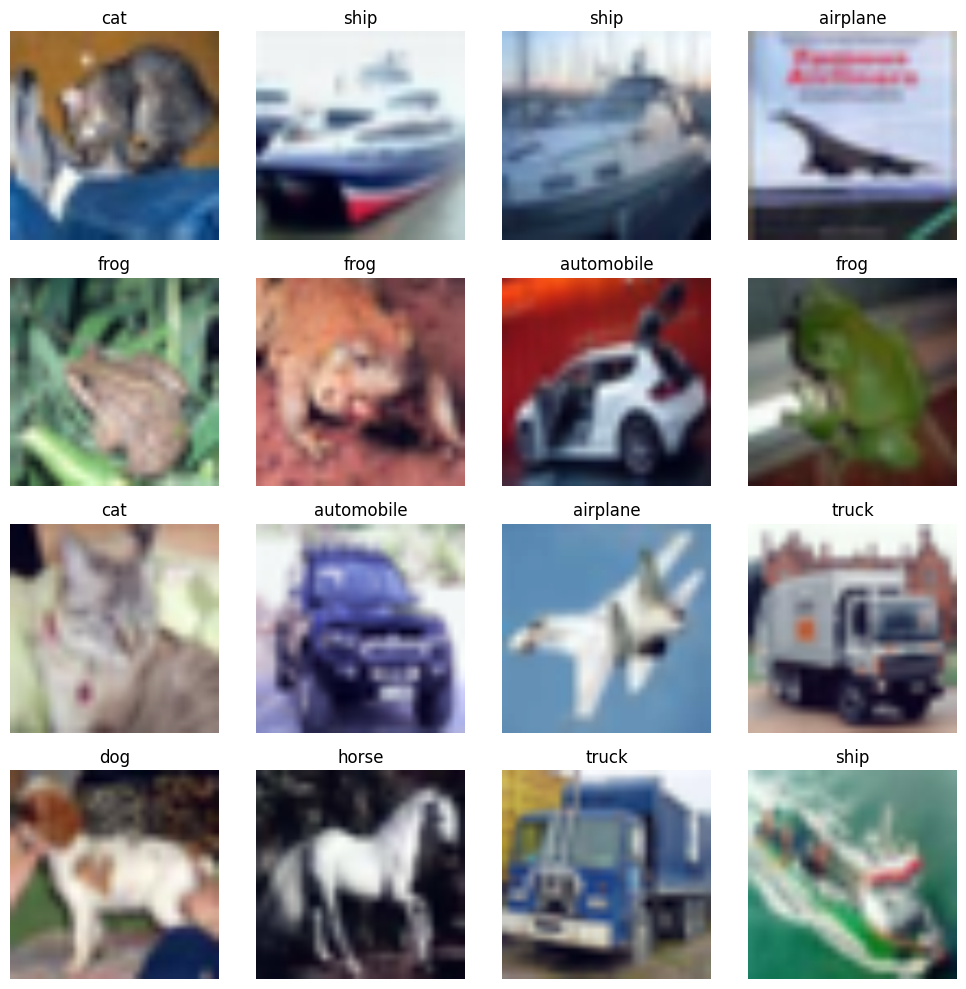

In [6]:
plot_images(images[:16], labels[:16], classes, normalize=True)

In [7]:
model = AlexNet(in_channels=3, out_features=10)
model.load_state_dict(torch.load("./saved/alex_net_CIFAR10.pth", map_location="mps"))

trainer = Trainer(
    model=model,
    dataset=dataset,
    loss_name="cross_entropy",
    optimizer_name="SGD",
    optmizer_params={
        "momentum": 0.9,
        "weight_decay": 0.0005,
    },
    lerarning_schedule_params={
        "mode": "min",
        "factor": 0.1,
        "patience": 5,
    },
    lr=0.01,
    device="mps",
)

╭─ Experiment Config ─╮
│ Starting Training   │
│ Model: AlexNet      │
│ Dataset: cifar10    │
│ Device: mps         │
╰─────────────────────╯

In [8]:
y_hat, y_true, val_err, probs = trainer.make_predictions()

In [9]:
print(f"Test error: {val_err}")

Test error: 0.24119999999999997


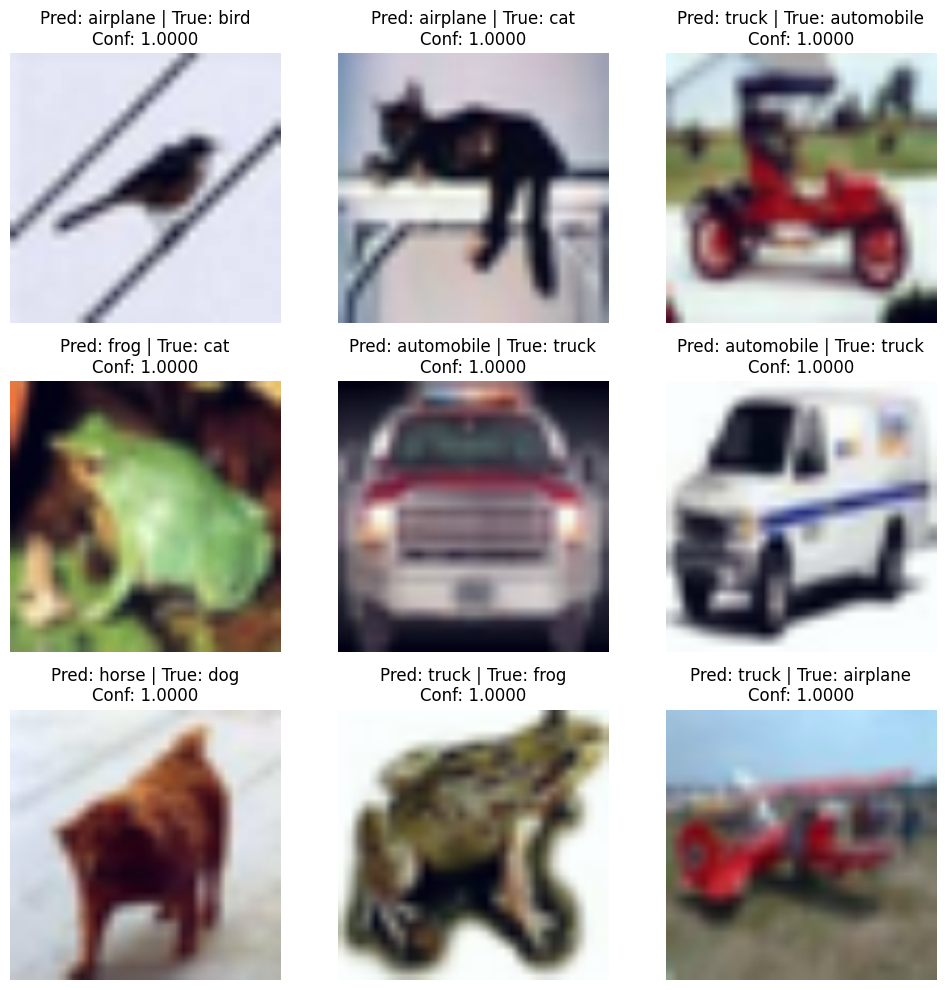

In [10]:
mistakes = get_top_k_confident_mistakes(y_hat, y_true, probs, k=9)
plot_top_mistakes(mistakes, classes, trainer)

Here we see that model was quiet close to the true predictions. And whats strange is that in picture 4 in the top i also thought that this is a frog, even though it was a cat

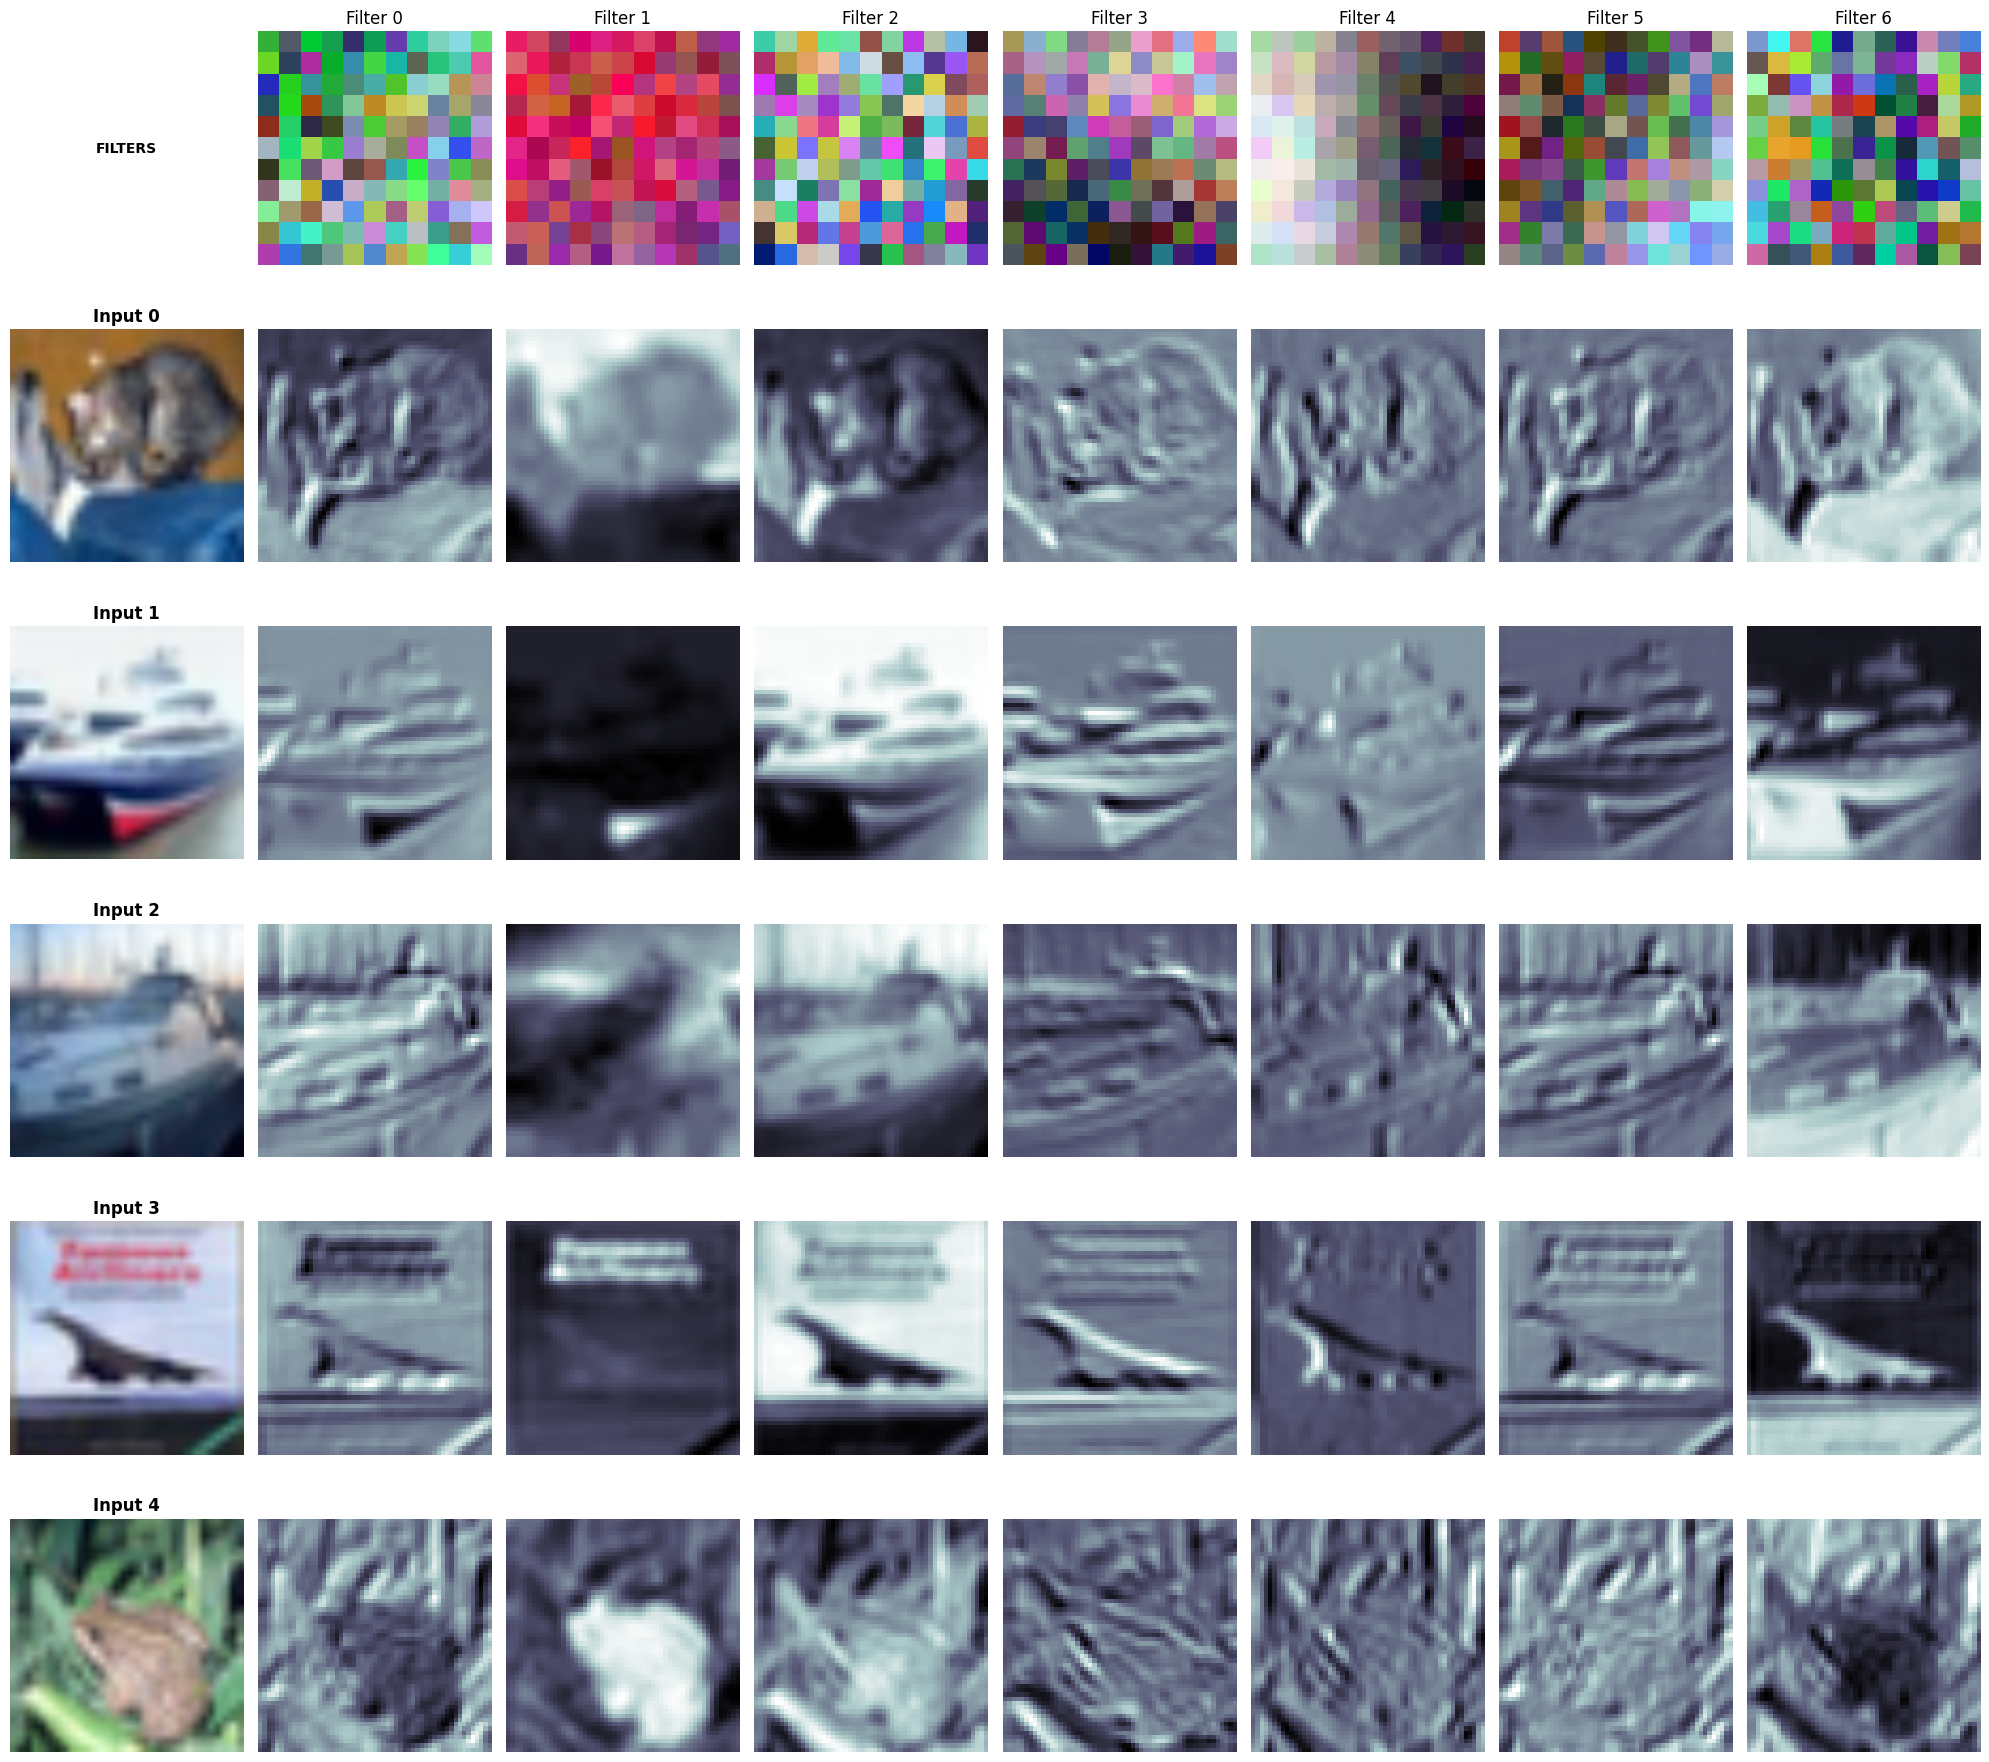

In [11]:
plot_filters_and_feature_maps(images, model, n_images=5, n_filters=7)

And we can see that each filter tries to detect something else, some other feature, and this is wonderful, this is the power of convolution operation and neural networks

In [12]:
history = torch.load("./saved/alex_net_CIFAR10_stats.pth")
history_with_tanh = torch.load("./saved/alex_net_CIFAR10_with_tanh_stats.pth")
history_without_weight_decay = torch.load("./saved/alex_net_CIFAR10_without_weight_decay_stats.pth")
history_without_dropout = torch.load("./saved/alex_net_CIFAR10_without_dropout_stats.pth")
history_without_lrn = torch.load("./saved/alex_net_CIFAR10_without_lrn_stats.pth")

1. AlexNet training on CIFAR10

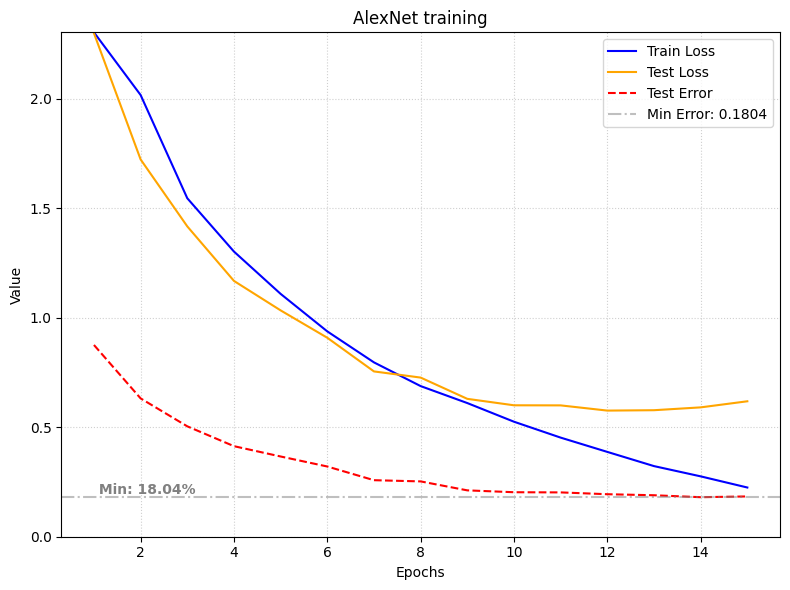

In [13]:
plot_training_results(history, titles=["AlexNet training"])

The model demonstrates strong initial convergence, with the Test Error stabilizing at ~18%. However, a clear divergence between Train Loss and Test Loss emerges after Epoch 12, signaling the onset of overfitting. To optimize performance and generalization we can use Early Stopping at Epoch 10 and introduce Data Augmentation to mitigate the gap between training and validation performance.

2. ReLU vs Tanh

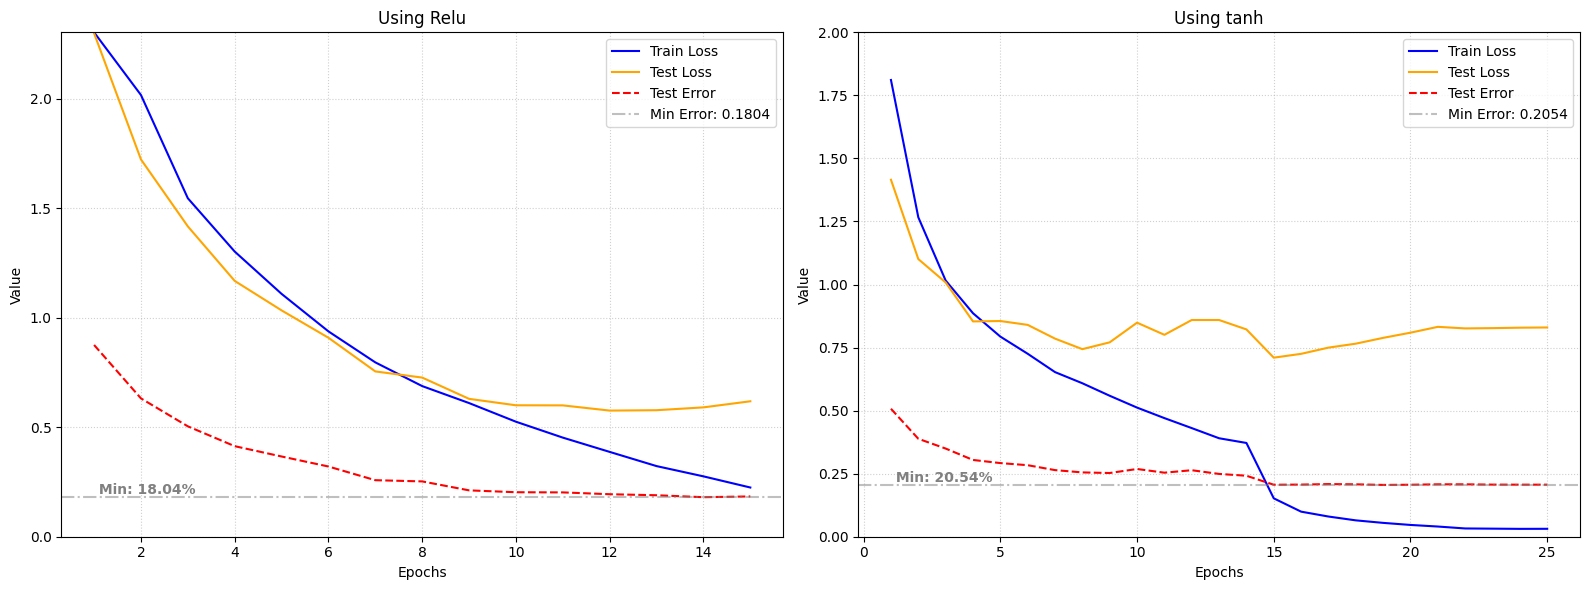

In [14]:
plot_training_results(history, history_with_tanh, titles=["Using Relu", "Using tanh"])

ReLU demonstrates faster and smoother convergence than Tanh, confirming its efficiency in deep networks.The Tanh plot shows high volatility in the test loss, suggesting it is more sensitive to initialization and prone to unstable gradients. ReLU reaches a lower test error (~18%) more predictably, making it the more reliable choice for the model's architecture. Both models begin to overfit after the first 10–12 epochs, as evidenced by the increasing gap between training and test loss.

3. With/without dropout

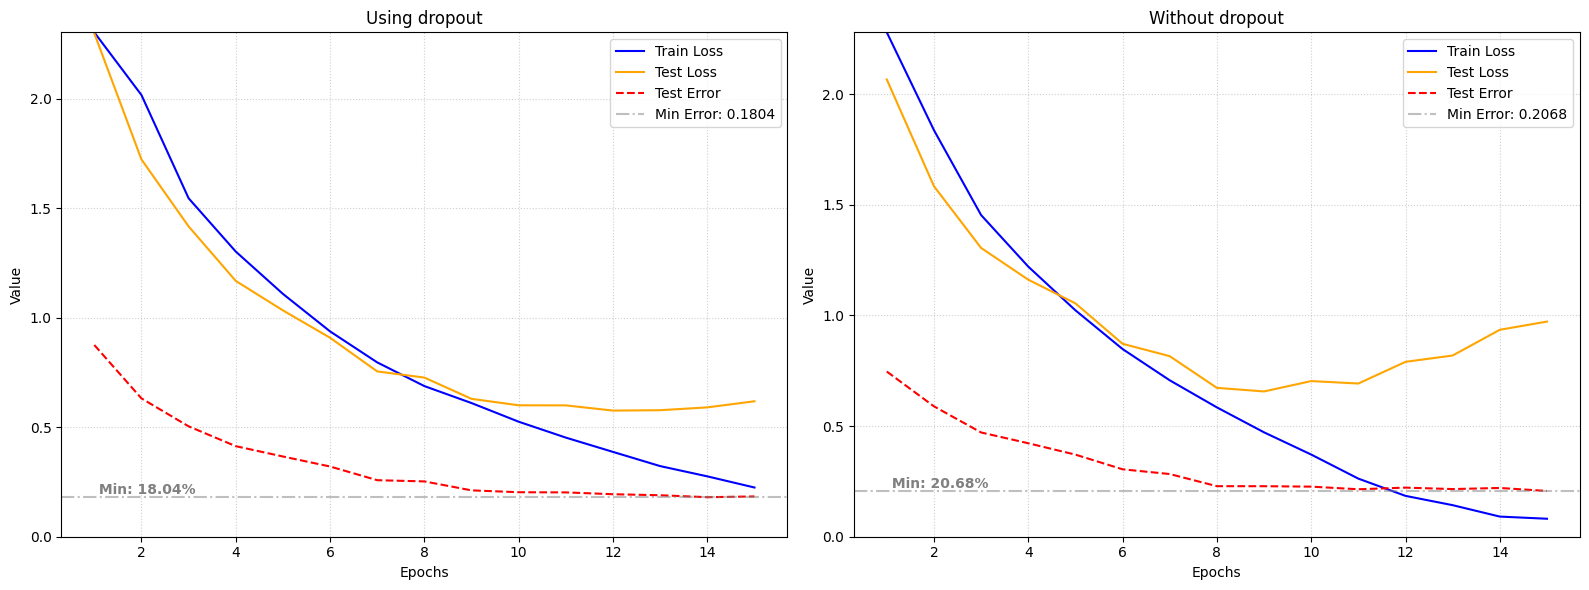

In [15]:
plot_training_results(history, history_without_dropout, titles=["Using dropout", "Without dropout"])

Without Dropout, the Train Loss approaches zero by Epoch 15, indicating that the model has nearly "perfectly" memorized the training set. The Test Loss (orange) begins to diverge and increase after Epoch 8. This widening gap between training and test performance is a clear sign that the model has ceased learning generalizable features and is instead overfitting to the noise in the dataset. With Dropout, the Minimum Test Error is lower (18.04% vs. 20.68%). Furthermore, the Test Loss remains significantly more stable, proving that Dropout effectively regularizes the network by preventing co-adaptation of neurons.

4. With/without weight decay

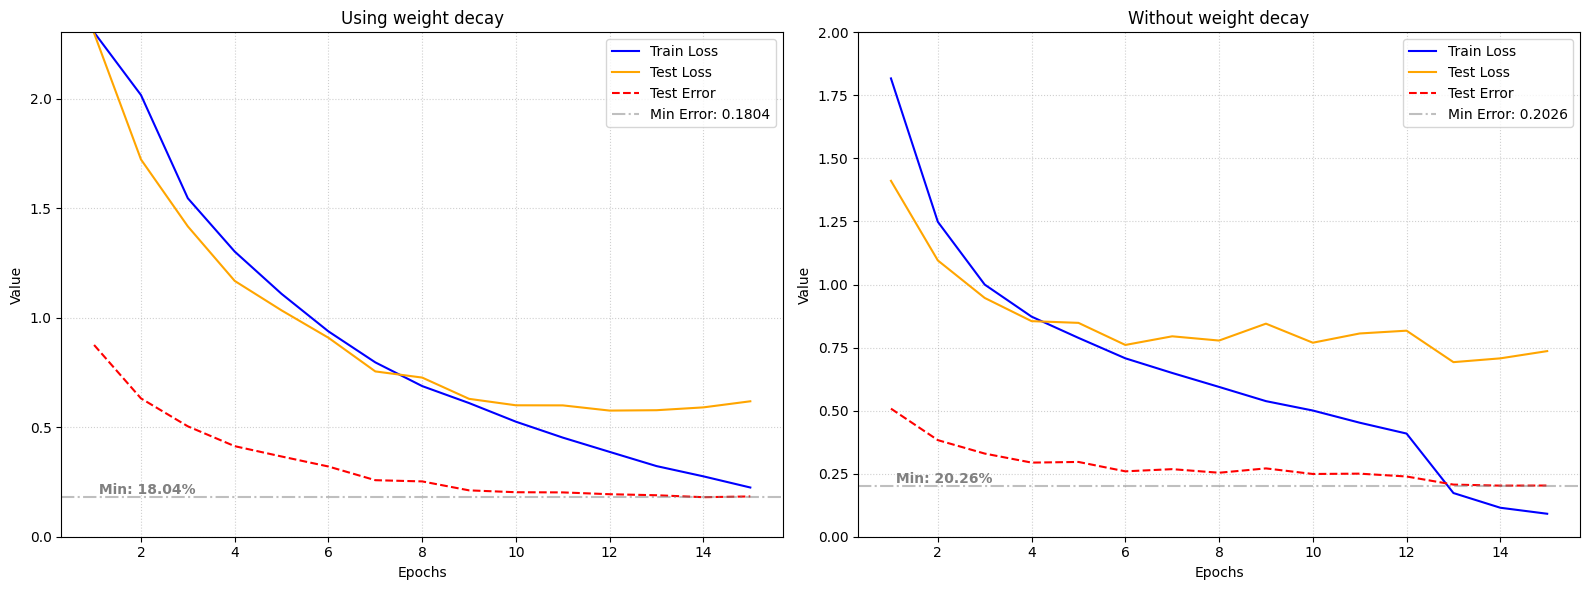

In [16]:
plot_training_results(history, history_without_weight_decay, titles=["Using weight decay", "Without weight decay"])

Here we clear picture: in the right plot, without weight decay, we allowed model to use weights whatever it wants and this is the reason of overfiting - training error is almost zero(follow the noise), while test error is not stable, because with the large weights, small shift can cause big difference.

5. With/without Local Response Normalization

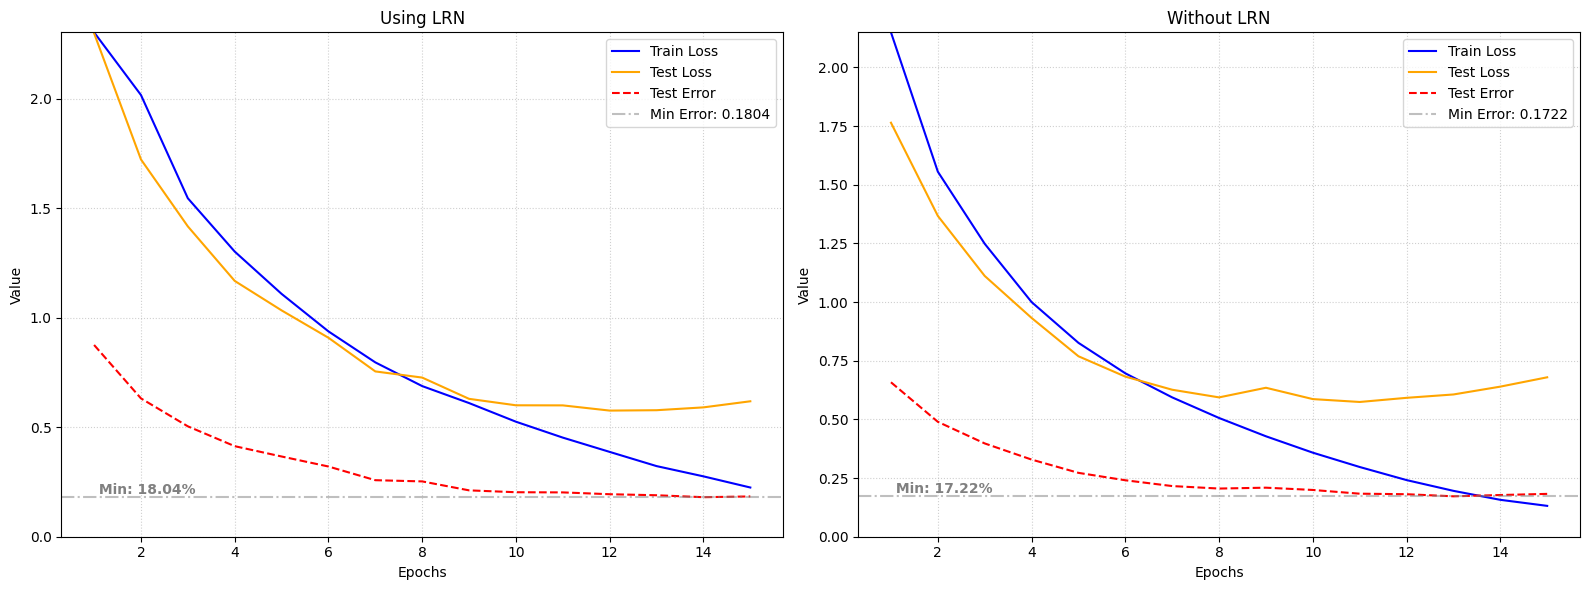

In [17]:
plot_training_results(history, history_without_lrn, titles=["Using LRN", "Without LRN"])